Training a model to count english syllables.  
Mostly adapted from https://www.kaggle.com/reppic/predicting-english-pronunciations

In [1]:
import json
import random
from collections import Counter, defaultdict

import numpy as np
import tensorflow as tf
from keras import callbacks, models, layers, optimizers
from matplotlib import pyplot as plt

from char_encoder import CharacterEncoder

In [2]:
CMUDICT_PATH = '../cmudict/cmudict.dict'

word_map = {}
with open(CMUDICT_PATH) as f:
    for line in f:
        word, *pieces = line.split()
        if '(' in word:  # Alternate pronunciation
            word = word[:word.index('(')]
        syllables = sum(p[-1].isdigit() for p in pieces)
        word_map.setdefault(word, []).append(syllables)
random.sample(list(word_map.items()), 10)

[('depicts', [2, 2]),
 ('treks', [1]),
 ('montmorency', [4]),
 ('neste', [1]),
 ('kilowatt', [3]),
 ('karolinska', [4]),
 ('reaney', [2]),
 ('salcedo', [3]),
 ('hops', [1]),
 ('francklin', [2])]

In [3]:
all_chars = ''.join(sorted({c for w in word_map for c in w}))
len(all_chars), all_chars

(29, "'-.abcdefghijklmnopqrstuvwxyz")

In [4]:
def plot_bar(some_dict, xlabel, ylabel, *, log=False, figsize=None, labelfunc=str):
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(some_dict.keys(), some_dict.values(), log=log)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(max(some_dict.keys()) + 1))
    for l, c in some_dict.items():
        ax.text(l, c, labelfunc(c), ha='center', va='top', rotation='vertical', color='white')
    plt.show()

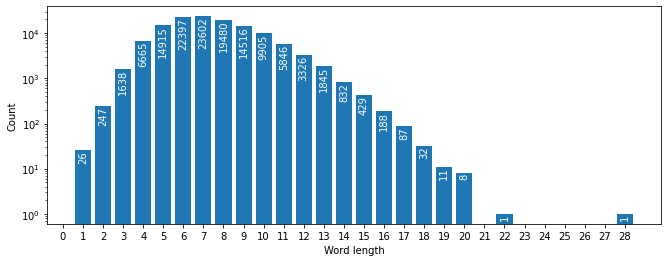

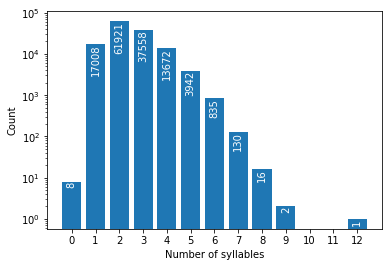

In [5]:
word_len_distrib = Counter(len(w) for w in word_map)
plot_bar(word_len_distrib, 'Word length', 'Count', log=True, figsize=(11, 4))

syllables_distrib = Counter(c for cnts in word_map.values() for c in cnts)
plot_bar(syllables_distrib, 'Number of syllables', 'Count', log=True)

In [6]:
duplicates = 0
for cnts in word_map.values():
    duplicates += len(cnts) - 1
duplicates, len(word_map), duplicates / len(word_map) * 100

(9096, 125997, 7.219219505226315)

In [7]:
# Decreasing the set of allowed chars and the max word len will decrease the size of the model.
EXCLUDED_CHARS = '.'  # Abbreviations
ALLOWED_CHARS = [c for c in all_chars if c not in EXCLUDED_CHARS]
MAX_WORD_LEN = 18

In [8]:
word_list, syllable_list = [], []
for w, cnts in word_map.items():
    if len(w) > MAX_WORD_LEN:
        continue
    if any(c in w for c in EXCLUDED_CHARS):
        continue
    word_list.append(w)
    syllable_list.append(cnts[0])  # Drop alternate pronunciations ¯\_(ツ)_/¯

char_enc = CharacterEncoder(ALLOWED_CHARS)

x = np.array([char_enc.encode(w, MAX_WORD_LEN) for w in word_list])
y = np.array(syllable_list)
x.shape, y.shape

((125862, 18, 28), (125862,))

In [9]:
np.random.seed(42)
shuffled_idx = np.random.permutation(len(x))
x, y = x[shuffled_idx], y[shuffled_idx]
word_list = [word_list[i] for i in shuffled_idx]

split_at = len(x) - len(x) // 4
x_train, x_val = x[:split_at], x[split_at:]
y_train, y_val = y[:split_at], y[split_at:]

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((94397, 18, 28), (31465, 18, 28), (94397,), (31465,))

In [10]:
MODEL_DIR = './model_data/model'
CHARS_FILE = './model_data/chars.json'

def acc(y_true, y_pred):
    """Prediction accuracy"""
    eq = tf.math.equal(y_true, tf.math.round(y_pred))
    eq = tf.reshape(eq, [-1])
    eq = tf.cast(eq, tf.int32)
    return tf.math.divide(tf.math.reduce_sum(eq), tf.shape(y_true)[0])

model = models.Sequential()
model.add(layers.Input(shape=x_train.shape[1:]))
model.add(layers.Bidirectional(layers.GRU(16, return_sequences=True)))
model.add(layers.GRU(16))
model.add(layers.Dense(1))

opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=[acc])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 18, 32)            4416      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stop = callbacks.EarlyStopping(patience=3)
model.fit(x_train, y_train,
          epochs=100,
          validation_data=(x_val, y_val),
          callbacks=[early_stop])

Epoch 1/100
2950/2950 [==============================] - 36s 12ms/step - loss: 0.2588 - acc: 0.7613 - val_loss: 0.1200 - val_acc: 0.8618
Epoch 2/100
2950/2950 [==============================] - 35s 12ms/step - loss: 0.1075 - acc: 0.8871 - val_loss: 0.0897 - val_acc: 0.9073
Epoch 3/100
2950/2950 [==============================] - 35s 12ms/step - loss: 0.0906 - acc: 0.9096 - val_loss: 0.0820 - val_acc: 0.9150
Epoch 4/100
2950/2950 [==============================] - 36s 12ms/step - loss: 0.0820 - acc: 0.9187 - val_loss: 0.0749 - val_acc: 0.9219
Epoch 5/100
2950/2950 [==============================] - 34s 11ms/step - loss: 0.0760 - acc: 0.9235 - val_loss: 0.0708 - val_acc: 0.9266
Epoch 6/100
2950/2950 [==============================] - 33s 11ms/step - loss: 0.0715 - acc: 0.9289 - val_loss: 0.0680 - val_acc: 0.9297
Epoch 7/100
2950/2950 [==============================] - 34s 11ms/step - loss: 0.0672 - acc: 0.9338 - val_loss: 0.0665 - val_acc: 0.9346
Epoch 8/100
2950/2950 [==================

In [12]:
y_pred = model.predict(x)
acc_by_len, acc_by_syl = defaultdict(lambda: [0, 0]), defaultdict(lambda: [0, 0])
overall_ok = overall_total = 0
for w, y_i, y_pred_i in zip(word_list, y, y_pred):
    y_pred_i = round(y_pred_i[0])
    ok = y_i == y_pred_i
    acc_by_len[len(w)][0] += ok
    acc_by_len[len(w)][1] += 1
    acc_by_syl[y_i][0] += ok
    acc_by_syl[y_i][1] += 1
    overall_ok += ok
    overall_total += 1
acc_by_len = {x: y / z for x, (y, z) in acc_by_len.items()}
acc_by_syl = {x: y / z for x, (y, z) in acc_by_syl.items()}

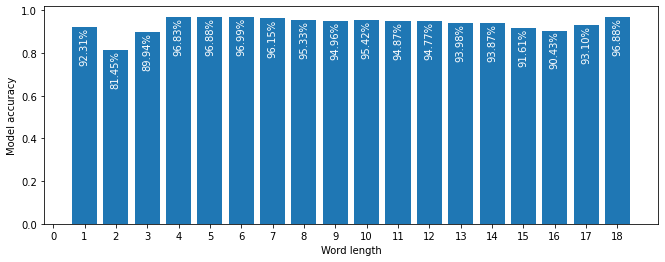

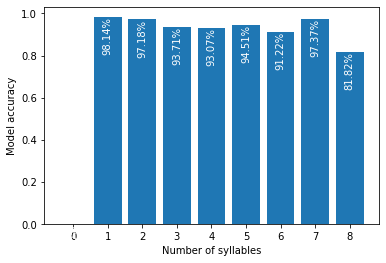

Overall accuracy: 95.82%


In [13]:
fmt_percent = lambda x: f'{x * 100:.2f}%'
plot_bar(acc_by_len, 'Word length', 'Model accuracy', figsize=(11, 4), labelfunc=fmt_percent)
plot_bar(acc_by_syl, 'Number of syllables', 'Model accuracy', labelfunc=fmt_percent)
print('Overall accuracy:', fmt_percent(overall_ok / overall_total))

In [15]:
model.save(MODEL_DIR)
with open(CHARS_FILE, 'w') as f:
    json.dump({'chars': ALLOWED_CHARS, 'maxlen': MAX_WORD_LEN}, f)

INFO:tensorflow:Assets written to: ./model_data/model/assets
